In [1]:
from sentinelhub import SHConfig

config = SHConfig()
config.sh_client_id = 'sh-fe080851-d462-4304-9f4d-1b7fd7c7dc95'
config.sh_client_secret = 'XBnxUPfjs1duw9wmexDpoVmhTbY6piHw'
config.sh_base_url = 'https://sh.dataspace.copernicus.eu'
config.sh_token_url = 'https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token'

In [2]:
import datetime
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio.transform import from_bounds
from pathlib import Path
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)


In [3]:
hyd_coords_wgs84 = (78.00405826,16.93264351,79.04971836,17.90150706)
resolution=(5500, 3500)
hyd_bbox = BBox(bbox=hyd_coords_wgs84, crs=CRS.WGS84)
hyd_size = bbox_to_dimensions(hyd_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {hyd_size} pixels")

Image shape at (5500, 3500) m resolution: (20, 30) pixels


In [4]:
evalscript_mean_mosaic = """
//VERSION=3
function setup() {
    return {
        input: ["NO2", "dataMask"],
        output: {
            bands: 1,
            sampleType: "FLOAT32",
        },
        mosaicking: "ORBIT"
    };
}

function isClear(sample) {
    return sample.dataMask == 1;
}

function sum(array) {
    let sum = 0;
    for (let i = 0; i < array.length; i++) {
        sum += array[i].NO2;
    }
    return sum;
}

function evaluatePixel(samples) {
    const clearTs = samples.filter(isClear)
    const mean = sum(clearTs) / clearTs.length
    return [mean]
}
"""

In [35]:
def get_data(time_interval):
    request = SentinelHubRequest(
        evalscript=evalscript_mean_mosaic,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL5P.define_from(
                    "s5pl2", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=hyd_bbox,
        size=hyd_size,
        config=config,
        data_folder="./data/1",
    )
    raw_data = request.get_data(save_data=False)
    return raw_data[0]

In [36]:
months = {
    1: ("January", 31),
    2: ("February", 28),
    3: ("March", 31),
    4: ("April", 30),
    5: ("May", 31),
    6: ("June", 30),
    7: ("July", 31),
    8: ("August", 31),
    9: ("September", 30),
    10: ("October", 31),
    11: ("November", 30),
    12: ("December", 31)
}
vals=[]
for i in range(1,13):
    month_name, end_day = months[i]
    start=f"2021-{i}-1"
    end = f"2021-{i}-{end_day}"
    time_interval=(start,end)
    vals.append(get_data(time_interval))
    
    


In [64]:
print(np.shape(vals))

(12, 30, 20)


In [68]:
for val in vals:
    print(val)
    break

[[2.9269590e-05 2.8407665e-05 2.6500120e-05 2.6353266e-05 2.7549440e-05
  2.5862139e-05 2.6629845e-05 2.5107372e-05 3.1814499e-05 2.7899501e-05
  2.8396591e-05 2.8006716e-05 3.0102026e-05 2.9260878e-05 2.9248638e-05
  2.4919089e-05 2.5703515e-05 2.4115770e-05 2.4533523e-05 2.5268420e-05]
 [2.9985998e-05 3.1812622e-05 2.9318289e-05 2.6235341e-05 2.6789145e-05
  2.2649840e-05 2.8030065e-05 2.6080115e-05 3.0146553e-05 3.0077248e-05
  2.9012879e-05 2.6902506e-05 3.0218818e-05 2.9442708e-05 2.6371006e-05
  2.6214055e-05 2.5449099e-05 2.4883175e-05 2.1324744e-05 2.2209893e-05]
 [3.0214560e-05 3.2106134e-05 2.8074621e-05 2.7055112e-05 2.8762090e-05
  2.5987238e-05 2.9695077e-05 2.6063561e-05 3.4089637e-05 3.1400010e-05
  2.8576816e-05 3.0913612e-05 3.1206848e-05 2.7785098e-05 2.3865894e-05
  2.4508061e-05 2.3390852e-05 2.4071009e-05 2.5220988e-05 2.3143435e-05]
 [3.0976469e-05 3.2760669e-05 3.1556177e-05 2.9295739e-05 3.0723982e-05
  2.9921139e-05 2.7802600e-05 3.2358246e-05 3.2093645e-05 3.2

In [74]:
new_vals=[]
for val in vals:
    new_vals.append(val.tolist())

In [75]:
print(new_vals)

[[[2.9269589504110627e-05, 2.840766501321923e-05, 2.6500119929551147e-05, 2.6353265639045276e-05, 2.7549440346774645e-05, 2.5862138500087894e-05, 2.6629844796843827e-05, 2.5107372493948787e-05, 3.181449937983416e-05, 2.7899501219508238e-05, 2.8396591005730443e-05, 2.8006716092932038e-05, 3.0102026357781142e-05, 2.9260878363857046e-05, 2.9248638384160586e-05, 2.4919088900787756e-05, 2.570351534814108e-05, 2.4115770429489203e-05, 2.453352317388635e-05, 2.5268420358770527e-05], [2.9985998480697162e-05, 3.18126221827697e-05, 2.931828930741176e-05, 2.6235340556013398e-05, 2.678914461284876e-05, 2.2649839593213983e-05, 2.8030064640915953e-05, 2.608011527627241e-05, 3.014655339939054e-05, 3.007724808412604e-05, 2.9012879167567007e-05, 2.690250585146714e-05, 3.021881821041461e-05, 2.9442708182614297e-05, 2.637100624269806e-05, 2.6214054742013104e-05, 2.5449098757235333e-05, 2.4883174774004146e-05, 2.13247440115083e-05, 2.220989335910417e-05], [3.021455995622091e-05, 3.210613431292586e-05, 2.80

In [78]:
print(np.shape(new_vals))

(12, 30, 20)


In [77]:
import json
with open('array_file.json', 'w') as f:
    json.dump(new_vals, f)

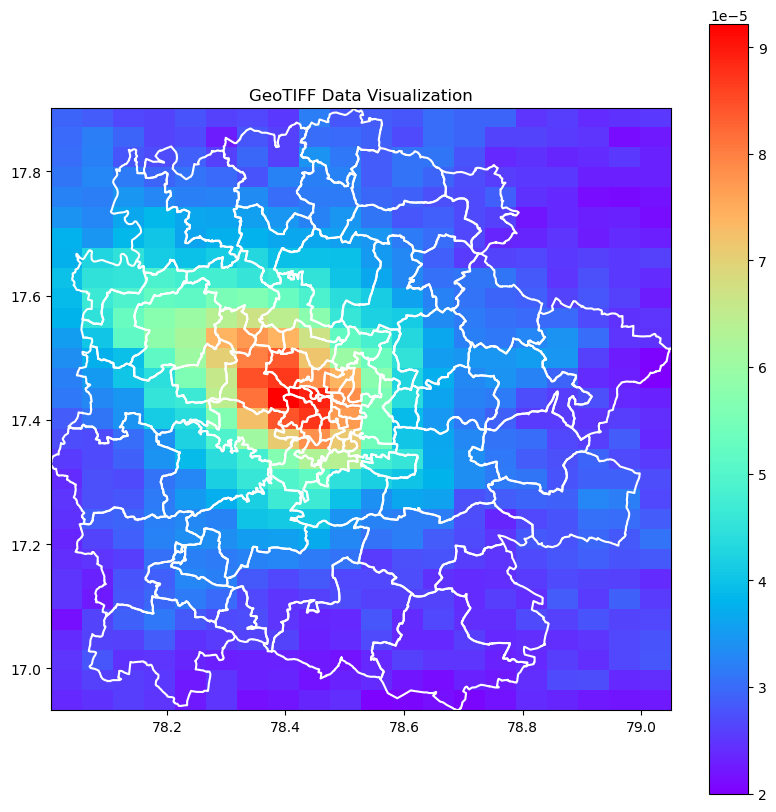

In [ ]:
import geopandas as gpd

# Load the shapefile
shapefile_path = r'C:\Users\rishi\ml_projects\climate\hmda_boundary\hmda_boundary.shp'
gdf = gpd.read_file(shapefile_path)

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

# Load the GeoTIFF file
tiff_file = r'C:\Users\rishi\ml_projects\climate\data\1\9aa0453d347cb978bd8d22f603a7eb9e\response.tiff'
with rasterio.open(tiff_file) as dataset:
    # Display the image with geospatial context
    fig, ax = plt.subplots(figsize=(10, 10))
    show(dataset, ax=ax, cmap='rainbow')
    plt.title('GeoTIFF Data Visualization')
    plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
    gdf.boundary.plot(ax=ax, edgecolor='white')
    plt.show()


In [ ]:
with rasterio.open(tiff_file) as dataset:
    # Print metadata
    print(dataset.meta)
    num_bands = dataset.count
    print(f"The GeoTIFF file has {num_bands} band(s).")
    # Get the spatial extent (bounding box)
    print("Bounds:", dataset.bounds)
    
    # Read the data as a numpy array (e.g., first band)
    data = dataset.read(1)
    print("Data shape:", data.shape)
    print(data)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 20, 'height': 30, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.05228300500000031, 0.0, 78.00405826,
       0.0, -0.032295451666666725, 17.90150706)}
The GeoTIFF file has 1 band(s).
Bounds: BoundingBox(left=78.00405826, bottom=16.93264351, right=79.04971836, top=17.90150706)
Data shape: (30, 20)
[[2.9269590e-05 2.8407665e-05 2.6500120e-05 2.6353266e-05 2.7549440e-05
  2.5862139e-05 2.6629845e-05 2.5107372e-05 3.1814499e-05 2.7899501e-05
  2.8396591e-05 2.8006716e-05 3.0102026e-05 2.9260878e-05 2.9248638e-05
  2.4919089e-05 2.5703515e-05 2.4115770e-05 2.4533523e-05 2.5268420e-05]
 [2.9985998e-05 3.1812622e-05 2.9318289e-05 2.6235341e-05 2.6789145e-05
  2.2649840e-05 2.8030065e-05 2.6080115e-05 3.0146553e-05 3.0077248e-05
  2.9012879e-05 2.6902506e-05 3.0218818e-05 2.9442708e-05 2.6371006e-05
  2.6214055e-05 2.5449099e-05 2.4883175e-05 2.1324744e-05 2.2209893e-05]
 [3.0214560e-05 3.2106134e-05 2.8074621e-05 